As for *config* we will use AutoConfig module from transformers which will import default configuration of pretrained model.

In [2]:
#import pretrained model first

from transformers import AutoTokenizer,BertModel,AutoConfig

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = BertModel.from_pretrained(model_ckpt)
text = "time flies like an arrow"

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

- *torch* is the top-level package in PyTorch. It provides functionality for creating and manipulating tensors, which are the fundamental building blocks in PyTorch. Tensors are multi-dimensional arrays, similar to NumPy arrays, and they can be used to represent data for various mathematical operations.
The torch package includes tensor operations, mathematical functions, and other utilities for working with numerical data.

- *torch.nn* (neural networks) is a module within PyTorch that provides tools for building and training neural networks. It includes pre-defined layers, loss functions, optimization algorithms, and other components necessary for constructing and training neural network models.

In [3]:

import torch.nn as nn
config = AutoConfig.from_pretrained(model_ckpt)
inputs = tokenizer(text,return_tensors = "pt",add_special_tokens = False)
embedding_layer = nn.Embedding(config.vocab_size, config.hidden_size)

In [4]:
embedding_layer

Embedding(30522, 768)

In [5]:
inputs

{'input_ids': tensor([[ 2051, 10029,  2066,  2019,  8612]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

Embedding Layer receives
- hidden_state size is a matrix lenght of one token with respect to context or other words.
- vocab size is number unique words in vocabulary.
As we are using pretrained model we are import data has been trained on by AutoConfig.

In [6]:
input_emb = embedding_layer(inputs.input_ids) # we only required tokens for the model
input_emb.size()

torch.Size([1, 5, 768])

In [7]:
config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [8]:
embedding_layer

Embedding(30522, 768)

In [9]:
import torch
import torch.nn.functional as F
import torch.nn as nn

def scaled_dot_product_attention(q,k,v):

  dim_k = k.size(-1)
  scores = torch.bmm(q,k.transpose(1,2))//sqrt(dim_k)
  weights = F.softmax(scores,dim = 1)

  return torch.bmm(weights,v)


In [10]:
class SelfAttention(nn.Module):

  def __init__(self,embed_dim,head_dim):
    super().__init__()

    self.q = nn.Linear(embed_dim,head_dim)
    self.k = nn.Linear(embed_dim,head_dim)
    self.v = nn.Linear(embed_dim,head_dim)

  def forward(self,hidden_state):

    attn_outputs = scaled_dot_product_attention(self.q(hidden_state),self.k(hidden_state),
                                                     self.v(hidden_state))

    return attn_outputs


**embed_dim* refers to the dimensionality of the input embeddings. In the context of natural language processing, it represents the size of the vector space in which words or tokens are embedded.
For example, if each word in a language is represented by a 300-dimensional vector, then embed_dim would be 300.
Head Dimension (head_dim):

**head_dim** is the dimensionality of the transformed vectors within each attention head in a multi-head attention mechanism.
In the context of multi-head attention, the input embedding vectors are linearly transformed into three sets of vectors (query, key, and value) for each attention head. head_dim represents the dimensionality of these transformed vectors.
It's common to choose head_dim as a fraction of embed_dim. For example, if embed_dim is 300 and there are 3 attention heads, then head_dim might be set to 100.
Number of Heads (num_heads):

**num_heads** is the number of parallel attention heads in a multi-head attention mechanism.
Each attention head captures different aspects of relationships and dependencies within the input sequence. Having multiple heads allows the model to attend to different parts of the input sequence simultaneously.
A larger num_heads can capture more complex patterns but comes with increased computational complexity.

- self.q = nn.Linear(embed_size,head_dim) is initializing the random weights (Qq) in this case.

- self.q(hidden_state) is basically matrix multiplication of Embedded vector and Qq(randomly initialized weights) to form q.

similarly others


In [13]:
config = AutoConfig.from_pretrained(model_ckpt)
config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [14]:
from math import sqrt
class MultiAttentionHead(nn.Module):

  def __init__(self,config):

    super().__init__()
    #Will not use self.embed_dim as
    embed_dim = config.hidden_size
    num_attention_head = config.num_attention_heads
    head_dim = embed_dim//num_attention_head

    self.heads = nn.ModuleList([SelfAttention(embed_dim,head_dim) for _ in range(num_attention_head)])
    self.output_linear = nn.Linear(embed_dim,embed_dim)

  def forward(self,hidden_state):

    x = torch.cat([h(hidden_state) for h in self.heads],dim = -1)
    x = self.output_linear(x)
    return x

- In above code we making number of multi heads we need.
- In *def forward(self,hidden)*: We concatenating the results obtained from each hidden layer along the last dim (dim=-1)
As return the concatenated tensor for the furthur process.

- Notice that the concatenated output from the attention heads is also fed through a
final linear layer to produce an output tensor of shape [batch_size, seq_len,
hidden_dim]

In [15]:
multihead_attn = MultiAttentionHead(config)
attn_outputs = multihead_attn(input_emb)
attn_outputs.size()

torch.Size([1, 5, 768])

In [16]:
class FeedForward(nn.Module):

  def __init__(self,config):

    super().__init__()
    self.linear_1 = nn.Linear(config.hidden_size,config.intermediate_size)
    self.linear_2 = nn.Linear(config.intermediate_size,config.hidden_size)
    self.gelu = nn.GELU() #Gaussian Error Linear Unit Activation Function
    self.dropout = nn.Dropout(config.hidden_dropout_prob)


  def forward(self,x):

    x = self.linear_1(x)
    x = self.gelu(x)
    x = self.linear_2(x)
    x = self.dropout(x)

    return x

Linear Layer 1 (self.linear_1):

This linear layer transforms the input tensor from a dimension of config.hidden_size to config.intermediate_size.
The transformation is learned during the training process through the optimization of weights and biases associated with this linear layer.
The purpose of this transformation is to project the input features into an intermediate space, allowing the model to capture complex patterns and relationships in the data.

Linear Layer 2 (self.linear_2):

This linear layer transforms the tensor from the intermediate space (dimension config.intermediate_size) back to the original space (dimension config.hidden_size).
Similar to the first linear layer, the transformation is learned during training.
The purpose of this second linear layer is to map the intermediate representations back to the original dimension, providing a mechanism for the model to reconstruct the original features.
Why Two Linear Layers:

The use of two linear layers with an intermediate dimension is a common design in feedforward layers within transformer architectures.
The first linear layer allows the model to capture complex relationships in a higher-dimensional space, introducing non-linearity through learned weights and biases.
The second linear layer projects the representations back to the original dimension, serving as a form of dimensionality reduction.

In [17]:
feed_forward = FeedForward(config)
ff_output = feed_forward(attn_outputs)
ff_output.size()

torch.Size([1, 5, 768])

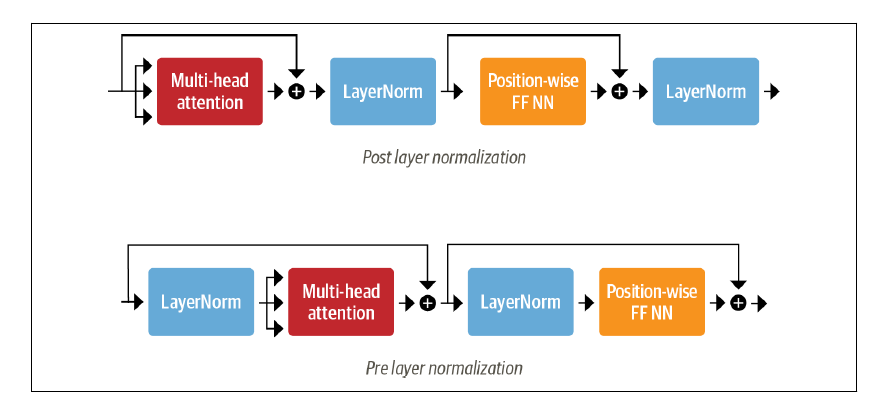

We Are using Pre Layer Normalization:


Post layer normalization
- This is the arrangement used in the Transformer paper; it places layer normalization
in between the skip connections. This arrangement is tricky to train from
scratch as the gradients can diverge. For this reason, you will often see a concept
known as learning rate warm-up, where the learning rate is gradually increased
from a small value to some maximum value during training.


Pre layer normalization
- This is the most common arrangement found in the literature; it places layer normalization
within the span of the skip connections. This tends to be much more
stable during training, and it does not usually require any learning rate warm-up.

In [18]:
class TransformerEncoderLayer(nn.Module):

  def __init__(self,config):

    super().__init__()

    self.layer_norm_1 = nn.LayerNorm(config.hidden_size)
    self.layer_norm_2 = nn.LayerNorm(config.hidden_size)
    self.attention = MultiAttentionHead(config)
    self.FeedForward = FeedForward(config)

  def forward(self,x):

    hidden_state = self.layer_norm_1(x)

    x = x + self.attention(hidden_state)

    x = x + self.FeedForward(self.layer_norm_2(x))

    return x

- As According to the process in Architecture we have formed a structure of Two Layer Normalization,MultiheadAttention, FeedForward.


- In Forward fn we are first normalizing the hidden_state then it goes to multiheadattention layer which results is added to the original input tensor x.

- Seconldy the Added and Normalized layer goes to Feed Forward Layer , the result output is added with the result of Add and Normalize layer after Attention Layer.



In [19]:
encoder_layer = TransformerEncoderLayer(config)
input_emb.shape

torch.Size([1, 5, 768])

In [20]:
encoder_layer(input_emb).size()

torch.Size([1, 5, 768])

### Position Embedding

In [21]:
class PostionEmbedding(nn.Module):

  def __init__(self,config):
    super().__init__()

    self.token_embeddings = nn.Embedding(config.vocab_size,config.hidden_size)

    self.position_embeddings = nn.Embedding(config.max_position_embeddings,config.hidden_size)
    self.layer_norm = nn.LayerNorm(config.hidden_size,eps = 1e-12)
    self.dropout = nn.Dropout()

  def forward(self,input_ids):

    seq_length = input_ids.size(-1)
    position_ids = torch.arange(seq_length,dtype = torch.long).unsqueeze(0)

    token_embedding = self.token_embeddings(input_ids)
    position_embedding = self.position_embeddings(position_ids)

    embeddings = token_embeddings + position_embeddings
    embeddings = self.layer_norm(embeddings)
    embeddings = self.dropout(embeddings)


After The Encoder we will move forward to Decoder Part.

As Decoder has two attention Sublayer:
1. Mask Multi Head Self Attention Layer.
2. Encoder Decoder Attention Layer

Musk self attention layer is to ensure the token we are generate at each output is based on past output and current output being predicted.ithout this, the decoder could
cheat during training by simply copying the target translations; masking the
inputs ensures the task is not trivial.


In traditional transformers its a sequence wise ouput prediction (i.e left to right or right to left) but in BERT the mask words are required to be predicted by a transformers are in both direction.

Encoder-decoder attention layer
Performs multi-head attention over the output key and value vectors of the
encoder stack, with the intermediate representations of the decoder acting as the
queries.6 This way the encoder-decoder attention layer learns how to relate
tokens from two different sequences, such as two different languages. The
decoder has access to the encoder keys and values in each block.

In [22]:
seq_len = inputs.input_ids.size(-1)
mask = torch.tril(torch.ones(seq_len,seq_len)).unsqueeze(0)
mask

tensor([[[1., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 0.],
         [1., 1., 1., 1., 1.]]])

we’ve used PyTorch’s tril() function to create the lower triangular matrix.
Once we have this mask matrix, we can prevent each attention head from peeking at
future tokens by using Tensor.masked_fill() to replace all the zeros with negative
infinity

The unsqueezing is a common practice when dealing with batched sequences to maintain compatibility with the batched nature of modern deep learning frameworks like PyTorch or TensorFlow

In [23]:
def scaled_dot_product_attention(q,k,v,mask = None):
  dim_k = key.size(-1)
  scores = nn.bmm(q,k.transpose(1,2))//sqrt(dim_k)

  if mask is not None:
    scores = scores.masked_fill(mask==0,-float("inf"))
  weights = F.sofmax(scores)
  return weights.bmm(v)

In [27]:
class MaskSelfAttention(nn.Module):

  def __init__(self,embed_dim,head_dim):
    super().__init__()

    self.q = nn.Linear(embed_dim,head_dim)
    self.k = nn.Linear(embed_dim,head_dim)
    self.v = nn.Linear(embed_dim,head_dim)

  def forward(self,hidden_state):

    mask_attn_output = scaled_dot_product_attention(self.q(hidden_state),self.k(hidden_state),self.v(hidden_state))

    return mask_attn_output

In [ ]:
class MultiAttentionHeadDecoder(nn.Module):
  def __init__(self,config):

    super().__init__()
    self.embed_dim = config.add_cross_attention
    self.head_num = config.num_attention_heads
    self.head_dim = embed_dim//head_num

    self.output_layer = ([MaskSelfAttention] for _ in range(head_num))

    def forward(self,hidden_state):



In [28]:
config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}